## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
ReparaStd = 10

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

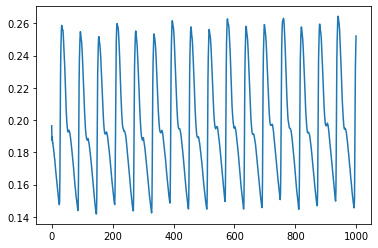

In [4]:
plt.plot(ValData[9])

### Post model

In [4]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]              
____

In [ ]:
SigGen_ZjFcAr, SigGen_ZjFcRand, SigGen_ZFc

In [42]:
Data= SigGen_ZFc
### Conducting FFT 
# Power Spectral Density
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :51])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]

# Probability Density Function
PS_PDF = PSD / np.sum(PSD, axis=(1, 2),keepdims=True)

# Power Spectral Entropy
PSE = -np.sum(PS_PDF * np.log(PS_PDF), axis=-1)

# Probability Density Function for Power Spectral Entropy
PSE_PDF = PSE / np.sum(PSE, axis=(-1),keepdims=True)

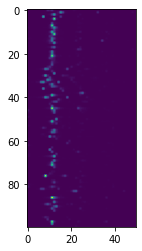

In [43]:
plt.imshow(PSD[5])

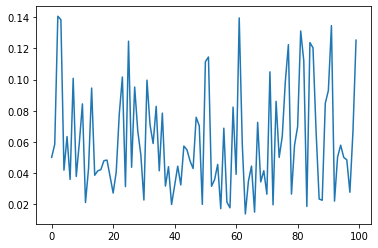

In [40]:
plt.plot(PSE[5])

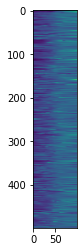

In [28]:
plt.imshow(PSE)

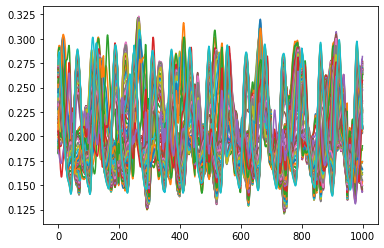

In [17]:
for i in range(100):
    plt.plot(SigGen_ZjFcAr[6][i])

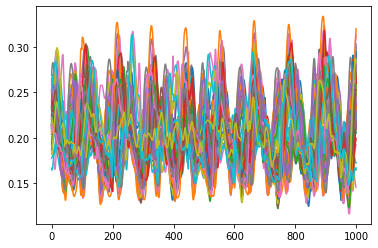

In [18]:
for i in range(100):
    plt.plot(SigGen_ZjFcRand[6][i])

In [57]:
PSE_PDF.shape

(500, 50)

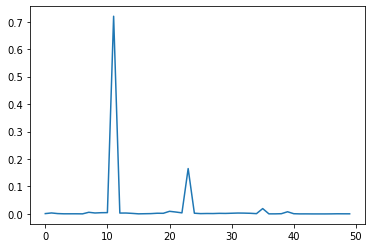

In [58]:
plt.plot(PSE_PDF[0])

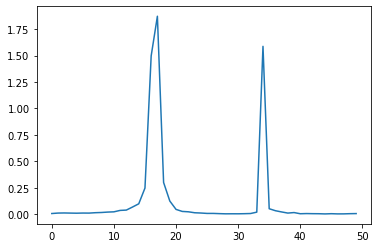

In [50]:
plt.plot(PSE[10])

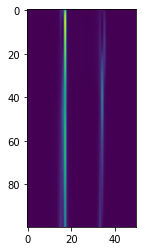

In [161]:
plt.imshow(PS_PDF[10])

In [24]:
# Power Spectral Density
PSD = ((NFreq*PSD_ModeMaxV_NG_ZFc)**2)/NGen
# Probability Density Function
PS_PDF = PSD / np.sum(PSD, axis=-1,keepdims=True)

# Power Spectral Entropy
PSE = np.sum(PS_PDF * np.log(PS_PDF), axis=-1)

In [41]:
def FFT_PS(Data, Metric, MinFreq = 1, MaxFreq = 51):
    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    PSD = (FFTRes**2)/FFTRes.shape[-1]
    
    # Probability Density Function
    PS_PDF = PSD / np.sum(PSD, axis=(1, 2),keepdims=True)
    # Power Spectral Entropy
    PSE = -np.sum(PS_PDF * np.log(PS_PDF), axis=-1)
    # Probability Density Function for Power Spectral Entropy
    PSE_PDF = PSE / np.sum(PSE, axis=(-1),keepdims=True)
    
    
    if 'PSD' == Metric:
        # (NMiniBat, NGen, NFreq)
        return PSD
    elif 'PS_PDF'  == Metric:
        # (NMiniBat, NGen, NFreq)
        return PS_PDF
    elif 'PSE'  == Metric:
        # (NMiniBat, NFreq)
        return PSE
    elif 'PSE_PDF' == Metric:
        # (NMiniBat, NFreq)
        return PSE_PDF
    
    


def ProbFreq (Data, NMiniBat, NGen, Axis, MeanZj=None, Metric ='PSD', MinFreq = 1, MaxFreq = 51, EpsProb = 1e-7):

    ### Conducting FFT 
    # Power Spectral Density
    PSD = FFT_PS(Data, Metric=Metric, MinFreq = MinFreq, MaxFreq = MaxFreq)

    ### Max PSD label
    MaxPSDLabel = np.argmax(PSD, axis=-1) + 1
    MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

    if Axis =='All':
        # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
        MaxV, Count = np.unique(MaxPSDLabel, return_counts=True)
        MaxVLabelCount[MaxV] = Count

        ### Probability of frequencies 
        Prob = MaxVLabelCount / np.sum(MaxVLabelCount)

    elif Axis =='One':
        MaxVLabelCount = []
        MaxV_MeanZj = []
        # Mini batch-wise max freqeuncy count
        for num, mini in enumerate(MaxPSDLabel):
            
            if MeanZj is not None: # To identify at which z-value the maximum of a particular frequency is often formed.
                MeanZj = MeanZj.reshape(NMiniBat, NGen, -1)
                MaxV_MeanZj.append(np.mean(MeanZj[num], axis=0)[None]) 
                
            Count_ = np.zeros_like(MaxVLabelIDX)
            MaxV, Count = np.unique(mini, return_counts=True)
            Count_[MaxV] = Count
            MaxVLabelCount.append(Count_[None])

        # (Batch_size, N_frequency)
        MaxVLabelCount = np.concatenate(MaxVLabelCount)    
        Prob = MaxVLabelCount / NGen 
    
    if MeanZj is not None:
        return np.maximum(Prob, EpsProb), np.concatenate(MaxV_MeanZj)    
    else:
        return np.maximum(Prob, EpsProb)
    
    
def Sampler (Data):
    Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, [Zs_Out, Z_Mu_Out, Z_Sigma_Out, FCs_Out])
    return Sampler.predict(Data, batch_size=2000, verbose=1)   

In [6]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 500
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1

In [44]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))
 

### monte carlo approximation
I_V_Z = 0
I_V_ZjZ = 0
I_V_Zj = 0
I_V_FRZj = 0
I_V_FAZj = 0


for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
          
            print('Sampling Samp_Zs and Samp_Fc')
            # Sampling
            SplitData_Ext =  np.broadcast_to(SplitData[mini][:, None], (NMiniBat, NGen, SplitData[mini].shape[-1])).reshape(-1, SplitData[mini].shape[-1])
            Samp_Z, Mu_Z, Sigma_Z, Samp_Fc = Sampler(SplitData_Ext)
            
            
            print('Predicting SigGen_ZFc')
            # Reconstruction; y ~ Q(Y | Z, Fc)Q(Z, Fc | Y)
            Rand_Fc = np.random.rand(NMiniBat *NGen, NFCs) * FcLimit
            FeatGen_ZFc = FeatGenModel.predict([Rand_Fc[:, :2],Rand_Fc[:, 2:], Samp_Z], batch_size=4000, verbose=1)
            SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            

            # Masking for selecting Samp_Zj from Samp_Z by assuming Zs with indices other than j have mean values '0' of Guassian dist.
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            Samp_Zj = Samp_Z * Mask_Z
            
            
            print('Predicting SigGen_ZjFc')
            # Reconstruction; y ~ Q(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); Assuming Zs with indices other than j have mean values '0'; j~U(), Z~N(0, std), and Fc ~ Bern(x;μ=0.5) x FcLimit
            FeatGen_ZjFc = FeatGenModel.predict([Rand_Fc[:, :2],Rand_Fc[:, 2:], Samp_Zj], batch_size=4000, verbose=1)
            SigGen_ZjFc = ReconModel.predict([FeatGen_ZjFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            # Selecting Samp_Zj from Guassian dist by assuming Zs with indices other than j have mean values '0' of Guassian dist and repeat the values NGen times.
            Samp_ZjRep = []
            for i in range(NMiniBat):
                Mask_Z = np.zeros((LatDim))
                # LatDim-wise Z sampling
                Mask_Z[ np.random.choice(LatDim, NSelZ,replace=False )]= np.random.normal(0, ReparaStd)
                # Setting the same Z value within the N generated signals (NGen).
                Samp_ZjRep.append(np.broadcast_to(Mask_Z[None], (NGen,LatDim))[None]) 
            Samp_ZjRep = np.concatenate(Samp_ZjRep).reshape(NMiniBat *NGen, LatDim)
            
            
            
            print('Predicting SigGen_Zj')
            # Reconstruction; y ~ P(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); j~U() Fc~U() and Z~N(0, std) 
            # Assuming all Fc ~ Bern(x;μ=0.5) x FcLimit
            FeatGen_ZjFcRand = FeatGenModel.predict([Rand_Fc[:, :2], Rand_Fc[:, 2:], Samp_ZjRep], batch_size=4000, verbose=1)
            SigGen_ZjFcRand = ReconModel.predict([FeatGen_ZjFcRand], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            print('Predicting SigGen_ZjFcAr')
            # Reconstruction; y ~ P(Y | Fc, Zj)Q(Zj); 
            # The Fc values on FC_Arange (FcAr) are generated based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            FeatGen_ZjFcAr = FeatGenModel.predict([FC_Arange[:, :2], FC_Arange[:, 2:], Samp_ZjRep], batch_size=4000, verbose=1)
            SigGen_ZjFcAr = ReconModel.predict([FeatGen_ZjFcAr], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
                             
                
            # Max frequency wise values
            Q_V = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'All', Metric='PSD',  MinFreq = 1, MaxFreq = 51)
            Q_V_Z = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj = ProbFreq (SigGen_ZjFc, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FR = ProbFreq (SigGen_ZjFcRand, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FA, MaxV_MeanZj = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', MeanZj=Samp_Zj, Metric='PSD', MinFreq = 1, MaxFreq = 51)
            
            
            
            # Max frequency entropy-wise values
            Q_VE = FFT_PS(SigGen_ZFc, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)
            Q_VE_Zj_FR = FFT_PS(SigGen_ZjFcRand, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)
            Q_VE_Zj_FA = FFT_PS(SigGen_ZjFcAr, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)
            
            
            
            # I(V;Z)
            I_V_Z_ = np.mean(np.sum(Q_V_Z * np.log(Q_V_Z / Q_V[None]), axis=-1))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_
            
            # I(V;Zj|Z)
            I_V_ZjZ_ = np.mean(np.sum(Q_V_Zj * np.log(Q_V_Zj / Q_V_Z), axis=-1))
            print('I_V_ZjZ : ', I_V_ZjZ_)
            I_V_ZjZ += I_V_ZjZ_
            
            # I(V;Zj)
            I_V_FRZj_ = np.mean(np.sum(Q_V_Zj_FR * np.log(Q_V_Zj_FR / Q_V), axis=-1))
            print('I_V_FRZj : ', I_V_FRZj_)
            I_V_FRZj += I_V_FRZj_
            
            # I(V;FC|Zj)
            I_V_FAZj_ = np.mean(np.sum(Q_V_Zj_FA * np.log(Q_V_Zj_FA / Q_V_Zj_FR), axis=-1))
            print('I_V_FAZj : ', I_V_FAZj_)
            I_V_FAZj += I_V_FAZj_
            
            
            t.update(1)


I_V_Z /= (MASize*SimSize)
I_V_ZjZ /= (MASize*SimSize)

# CMI(V;Zj, Z)
CMI_V_ZjZ = I_V_Z + I_V_ZjZ             

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Sampling Samp_Zs and Samp_Fc
25/25 [==============================] - 5s 132ms/step
Predicting SigGen_ZFc
13/13 [==============================] - 4s 307ms/step
Predicting SigGen_ZjFc
13/13 [==============================] - 4s 317ms/step
Predicting SigGen_Zj
13/13 [==============================] - 4s 319ms/step
Predicting SigGen_ZjFcAr
13/13 [==============================] - 4s 310ms/step


  1%|▋                                                                               | 1/120 [00:44<1:28:34, 44.66s/it]

I_V_Z :  0.12000493518979084
I_V_ZjZ :  1.3182887825484348
I_V_FRZj :  2.6022250259214177
I_V_FAZj :  0.22314567989960546
Sampling Samp_Zs and Samp_Fc
25/25 [==============================] - 6s 138ms/step
Predicting SigGen_ZFc
 4/13 [========>.....................] - ETA: 2s

KeyboardInterrupt: 

In [52]:
Q_VE_Zj_FR.shape

(500, 100)

In [45]:
np.mean(np.sum(Q_VE_Zj_FR * np.log(Q_VE_Zj_FR / Q_VE), axis=-1))

0.46347243318304515

In [46]:
np.mean(np.sum(Q_VE_Zj_FA * np.log(Q_VE_Zj_FA / Q_VE_Zj_FR), axis=-1))

0.1891747203122797

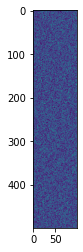

In [50]:
plt.imshow(Q_VE)

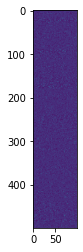

In [49]:
plt.imshow(Q_VE_Zj_FR)

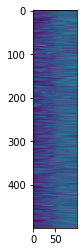

In [48]:
plt.imshow(Q_VE_Zj_FA)

In [89]:
Q_VE.shape

(500, 50)

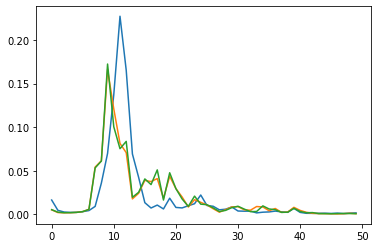

In [87]:
plt.plot(Q_VE[0])
plt.plot(Q_VE_Zj_NF[0])
plt.plot(Q_VE_Zj_FA[0])

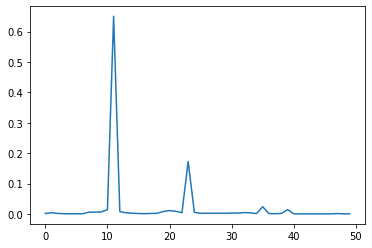

In [55]:
plt.plot(Q_VE_Zj_FA[0])

In [ ]:
            # Max frequency entropy-wise values
            Q_VE = FFT_PS(SigGen_ZFc, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)
            Q_VE_Zj_NF = FFT_PS(SigGen_Zj, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)
            Q_VE_Zj_FA = FFT_PS(SigGen_ZjFcAr, 'PSE_PDF', MinFreq = 1, MaxFreq = 51)

In [49]:
I_VE_ZjNF_ = np.mean(np.sum(Q_VE_Zj_NF * np.log(Q_VE_Zj_NF / Q_VE), axis=-1))
I_VE_ZjFA_ = np.mean(np.sum(Q_VE_Zj_FA * np.log(Q_VE_Zj_FA / Q_VE_Zj_NF), axis=-1))


1.6836618024562546

In [50]:
 np.mean(np.sum(Q_VE_Zj_FA * np.log(Q_VE_Zj_FA / Q_VE_Zj_NF), axis=-1))

0.1717117669949619

In [ ]:
 FeatGen_Zj = FeatGenModel.predict([Samp_Fc_Null[:, :2], Samp_Fc_Null[:, 2:], Samp_Zj], batch_size=4000, verbose=1)

In [292]:
Samp_Zj.shape

(500, 100, 50)

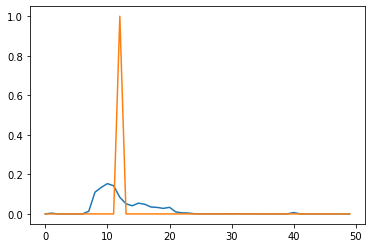

In [308]:
plt.plot(Q_V)
plt.plot(Q_V_Zj_FA[91])



In [ ]:
            Q_V   Q_V_Z Q_V_Zj  Q_V_Zj_NF Q_V_Zj_FA

In [42]:
MaxV_MeanZj[0]

array([ 0.        ,  0.00142618, -0.04591468, -0.03858455, -0.01835428,
        0.009306  , -0.02544727,  0.        , -0.00180658,  0.01909471,
       -0.01572306,  0.00656073,  0.01877734, -0.003918  ,  0.00948862,
       -0.00496202, -0.01715618, -0.02395445,  0.00340425, -0.01056157,
        0.01003529, -0.01603608, -0.01233093,  0.        ,  0.03623306,
        0.00828983,  0.00570921,  0.01190912,  0.00627315,  0.00014227,
        0.01078728,  0.00423105, -0.00545136, -0.0072295 ,  0.04677336,
       -0.02912462, -0.03282393,  0.00612001,  0.0079564 , -0.00983884,
        0.00212223,  0.00098124,  0.        ,  0.00186495, -0.00172255,
       -0.00828432,  0.00236936,  0.00925105,  0.00825056, -0.01940368])

In [29]:
MaxV_MeanZj.shape

(500, 50)

(500, 50)

In [97]:
Samp_Zj3d=None

In [13]:
AnalData = ValData

MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 300
Ndata = len(ValData)
MASize = Ndata//NMiniBat

FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,4))


# P_V
P_V = ProbFreq (AnalData, NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)

### monte carlo approximation
I_V_Z = 0
I_VFc_Z = 0

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
            
            P_V = ProbFreq (SplitData[mini], NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)
            
            Mask_Z = np.zeros((NMiniBat, LatDim))
            for i in range(NMiniBat):
                Mask_Z[i, np.random.choice(LatDim)] = 1

            # Sampling
            print('Sampling Samp_Zs and FCs_Z')
            Samp_Zs, FCs_Z = Sampler(SplitData[mini])
            Samp_Zs *= Mask_Z
            
            # To eliminate the effect of Fc on signal generation, the Fc_Mu = 0.5 is given as a constant.
            FCs_Z[:, :] = FcLimit * 0.5
            FC_Comm_Z = FCs_Z[:, :2]
            FC_Each_Z  = FCs_Z[:, 2:]

            # I(V;z)
            print('Predicting SigGen_Z')
            FeatGen_Z = FeatGenModel.predict([FC_Comm_Z,FC_Each_Z, Samp_Zs], batch_size=4000, verbose=1)
            SigGen_Z = ReconModel.predict([FeatGen_Z], batch_size=4000, verbose=1)
            Q_V_Z = ProbFreq (SigGen_Z, NMiniBat, NGen, MinFreq = 1, MaxFreq = 51)
            # I(V;z)
            I_V_Z_ = np.sum(Q_V_Z * np.log(Q_V_Z / P_V))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_


            # Expanding the data dimension for signal generation(random sampling) based on the frequency component (FC) 
            Samp_Zs_Ext =  np.broadcast_to(Samp_Zs[:, None], (NMiniBat, NGen, LatDim)).reshape(-1, LatDim)
            FC_Comm_Ext =  np.broadcast_to(FC_Comm[None], (NMiniBat, NGen, FC_Comm.shape[-1])).reshape(-1, FC_Comm.shape[-1])
            FC_Each_Ext =  np.broadcast_to(FC_Each[None], ( NMiniBat, NGen, FC_Each.shape[-1])).reshape(-1, FC_Each.shape[-1])

            # Q_V_ZFc
            print('Predicting SigGen_ZFc')
            FeatGen_ZFc = FeatGenModel.predict([FC_Comm_Ext,FC_Each_Ext, Samp_Zs_Ext], batch_size=4000, verbose=1)
            SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=4000, verbose=1).reshape(NMiniBat, NGen, -1)
            #SigGen_ZFc = SigGen_ZFc.reshape(NMiniBat*NGen, -1)
            Q_V_ZFc =ProbFreq (SigGen_ZFc, NMiniBat, NGen,  MinFreq = MinFreq, MaxFreq = MaxFreq)

            # I(V;Fc|z)
            I_VFc_Z_ = np.sum(Q_V_ZFc * np.log(Q_V_ZFc / Q_V_Z))
            print('I_VFc_Z : ', I_VFc_Z_)
            I_VFc_Z += I_VFc_Z_
            
            t.update(1)

I_V_Z /= (MASize*SimSize)
I_VFc_Z /= (MASize*SimSize)

I_V_z + I_VFc_z 

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

Sampling Samp_Zs and FCs_Z
1/1 [==============================] - 2s 2s/step


ValueError: too many values to unpack (expected 2)

In [ ]:
Mean.shape

In [5]:
def LogNormalDensity(LatSamp, LatMean, LogSquaScale):
    print(LatSamp.shape, LatMean.shape, LogSquaScale.shape)
    Norm = tf.math.log(2. * tf.constant(np.pi))
    InvSigma = tf.math.exp(-LogSquaScale)
    MeanSampDiff = (LatSamp - LatMean)
    return -0.5 * (MeanSampDiff * MeanSampDiff * InvSigma + LogSquaScale + Norm)

#### Labeling and data selection